# Промышленность
Компании необходимо уменьшить потребление электроэнергии на этапе обработки стали. В связи с чем нам нужно разработать **модель для предсказания температуры стали**.

## Описание этапов обработки

1) Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами 

*`data_arc.csv` — данные об электродах*


2) Температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом 

*`data_gas.csv` — данные о продувке сплава газом*


3) Добавлением примесей корректируется химический состав стали

*`data_bulk.csv/data_bulk_time.csv` — данные о подаче сыпучих материалов (объём/время)*

*`data_wire.csv/data_wire_time.csv` - данные о проволочных материалах (объём/время)*

4) Измеряют температуру стали и производят её химический анализ 

*`data_temp.csv` — результаты измерения температуры*


5) Повторяют этапы 2-4 : перемешивают и снова проводят измерения. Цикл повторяется до достижения целевого химического состава и **оптимальной температуры плавки**.

## План:
**1) Подготовить данные:**

    - загрузить таблицы, соединить их по столбцу `key` 
    
    - пропуски в данных о подаче материалов и газа заменить на 0
    
    - проверить данные на аномалии
    
    - удалить партии с одним измерением и те, где нет финального измерения
    
    
**2) Провести исследовательский анализ данных:** 

    - создать таблицу, где будут: целевой признак, суммарное время нагрева партии, полная мощность, суммарная активная мощность по партии, суммарное количество каждого вещества на каждую партию 
    
    - проверить на мультиколлинеарность

**3) Построить и обучить модель**

    - провести анализ важности признаков для каждой модели (feature_importances_/shap)

# Подготовка данных
## Подключение и настройка необходимых библиотек

In [1]:
# отключение предупреждений
import warnings; warnings.filterwarnings('ignore', category=Warning)

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
small, medium, large = 14, 16, 22 
params = {'figure.figsize': (12, 6),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error as mae

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

## Открытие и изучение файлов

In [5]:
#напишем функцю для загрузки файла, где file_path -- папка, содержащая df
def load_data(file_path, *args, **kwargs):
    """Загрузка датафрейма Pandas из локального файла file_path"""
    try:
        data = pd.read_csv(file_path, *args, **kwargs)
        print(f'Файл "{file_path}" загружен и готов к использованию')
    except FileNotFoundError:
        print('Загрузка файла через интернет')
        data = pd.read_csv('https://code.s3/'+file_path)
    return data

In [6]:
data_temp = load_data('/datasets/final_steel/data_temp.csv')

data_arc = load_data('/datasets/final_steel/data_arc.csv')
data_gas = load_data('/datasets/final_steel/data_gas.csv')

data_bulk = load_data('/datasets/final_steel/data_bulk.csv')
data_bulk_time = load_data('/datasets/final_steel/data_bulk_time.csv')

data_wire = load_data('/datasets/final_steel/data_wire.csv')
data_wire_time = load_data('/datasets/final_steel/data_wire_time.csv')

Файл "final_steel/data_temp.csv" загружен и готов к использованию
Файл "final_steel/data_arc.csv" загружен и готов к использованию
Файл "final_steel/data_gas.csv" загружен и готов к использованию
Файл "final_steel/data_bulk.csv" загружен и готов к использованию
Файл "final_steel/data_bulk_time.csv" загружен и готов к использованию
Файл "final_steel/data_wire.csv" загружен и готов к использованию
Файл "final_steel/data_wire_time.csv" загружен и готов к использованию


In [7]:
# заметили, что data_bulk/data_bulk_time и data_wire/data_wire_time имеют одинаковое название столбцов. Соединим и переименуем

bulk_wire_time = data_bulk_time.merge(data_wire_time, on='key', how='outer')

In [8]:
bulk_wire_time.columns = bulk_wire_time.columns +'_time'

In [9]:
bulk_wire_time = bulk_wire_time.rename(columns={'key_time': 'key'})

In [10]:
# соединим таблицы в одну
from functools import reduce

data_all = reduce(lambda x,y: pd.merge(x, y, on='key', how='outer'), 
                  [data_temp, data_arc, data_gas, data_bulk, data_wire, bulk_wire_time])

In [11]:
data_all.head()

,key,Время замера,Температура,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Газ 1,Bulk 1,Bulk 2,...,Bulk 15_time,Wire 1_time,Wire 2_time,Wire 3_time,Wire 4_time,Wire 5_time,Wire 6_time,Wire 7_time,Wire 8_time,Wire 9_time
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# переименуем для удобства
data_all = data_all.rename(columns={'Время замера': 'temp_time_check',
                                    'Температура': 'temp',
                                    'Начало нагрева дугой': 'heat_start', 
                                    'Конец нагрева дугой': 'heat_end', 
                                    'Активная мощность': 'active_power', 
                                    'Реактивная мощность': 'reactive_power',
                                    'Газ 1': 'gas_1'})

In [13]:
# приведем названия столбцов к одному стилю
data_all.columns = data_all.columns.str.replace(' ','_')
data_all.columns = data_all.columns.str.lower()

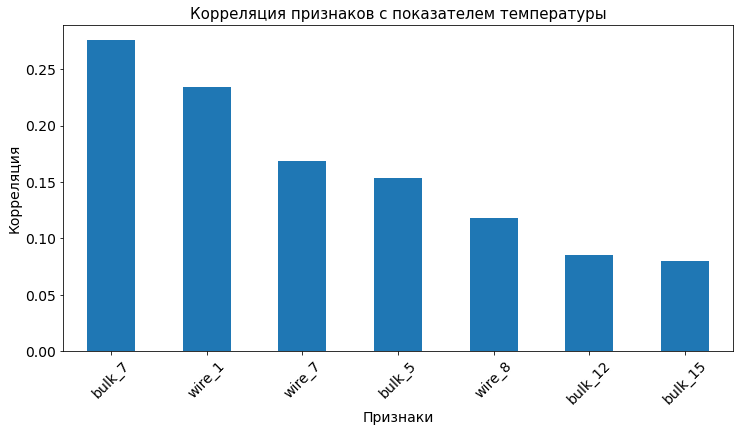

In [14]:
# посмотрим, какие показатели больше всего влияют на температуру

data_all.drop('temp', axis=1).corrwith(data_all['temp']).sort_values(ascending=False)[:7].plot(kind='bar')

plt.title('Корреляция признаков с показателем температуры', fontsize=15)
plt.xlabel('Признаки')
plt.ylabel('Корреляция')
plt.xticks(rotation=45);

Можно отметить, что температура стали зависит от опеределенных добавочных элементов (проволочных или сыпучих). Скорее всего это связано с тем, что при изменении химического состава сплава, меняется и температура его обработки. 

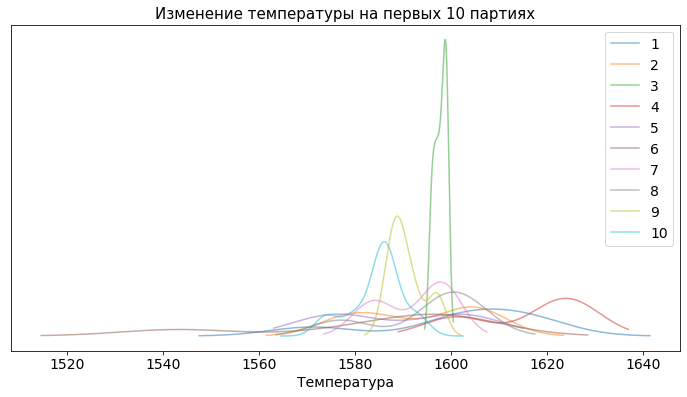

In [15]:
# посмотрим, как меняется температура по времени в разных партиях, попробуем выявить закономерности

fig, ax = plt.subplots(figsize=(12,6))
gp = data_all.query('key<11').groupby('key')['temp'].plot(kind='kde', ax=ax, legend=True, alpha=0.5)

plt.title('Изменение температуры на первых 10 партиях', fontsize=15)
plt.xlabel('Температура')
plt.ylabel('')
plt.yticks([]);

Судя по всему, температура не зависит от временных этапов, влияет именно состав сплава. 

**Выводы:** 
    
- температура плавки стали зависит от химического соcтва и меняется после добавления примесей
- целевой признак -- последнее измерение температуры в каждой партии

## Обработка пропусков и поиск аномалий в данных

### Обработка пропусков

In [16]:
data_all.isna().sum()

key                    0
temp_time_check       25
temp               14642
heat_start            27
heat_end              27
active_power          27
reactive_power        27
gas_1                 54
bulk_1             70270
bulk_2             76711
bulk_3             45673
bulk_4             53085
bulk_5             75241
bulk_6             62144
bulk_7             76653
bulk_8             78326
bulk_9             77817
bulk_10            73888
bulk_11            73765
bulk_12            16515
bulk_13            77252
bulk_14             8735
bulk_15            21213
wire_1              3188
wire_2             51774
wire_3             75438
wire_4             77416
wire_5             78160
wire_6             75401
wire_7             77318
wire_8             77817
wire_9             77735
bulk_1_time        70270
bulk_2_time        76711
bulk_3_time        45673
bulk_4_time        53085
bulk_5_time        75241
bulk_6_time        62144
bulk_7_time        76653
bulk_8_time        78326


- Пропуски в данных о добавлении материалов, скорее всего, означают, что этот компонент не был добавлен. Их заменим нулями.

- Пропуски в `heat_start`, `heat_end`, `active_power`, `reactive_power` заменять не станем, удалим эти данные. 

- Пропуски в показаниях температуры могут быть критичны для нас. Также нам важно проверить и удалить партии с одним измерением и те, где нет финального измерения температуры (так как это наш целевой признак)

In [17]:
data_all = data_all.dropna(subset=['temp_time_check', 'heat_start', 'heat_end', 'active_power', 'reactive_power'])

In [18]:
data_all

,key,temp_time_check,temp,heat_start,heat_end,active_power,reactive_power,gas_1,bulk_1,bulk_2,...,bulk_15_time,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,29.749986,NaN,NaN,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78312,3241,2019-09-01 04:38:08,NaN,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,12.680959,NaN,NaN,...,2019-09-01 04:05:34,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78313,3241,2019-09-01 04:38:08,NaN,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,12.680959,NaN,NaN,...,2019-09-01 04:05:34,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78314,3241,2019-09-01 04:38:08,NaN,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,12.680959,NaN,NaN,...,2019-09-01 04:05:34,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78315,3241,2019-09-01 04:38:08,NaN,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,12.680959,NaN,NaN,...,2019-09-01 04:05:34,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_all = data_all.fillna(0)

In [84]:
# проверим, есть ли в данных партии с одним измерением
key_count = data_all.groupby('key')['key'].count()
key_count[key_count < 2]

Series([], Name: key, dtype: int64)

Таких партий нет. 

### Добавление новых признаков

Создадим финальную таблицу, где индексом будут номера партий. Первое и последнее измерение температуры сделаем признаками. Заодно удалим партии, где есть пропуски в финальном измерении температуры. Также добавим в таблицу новые признаки.

#### Время нагрева

In [21]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78315 entries, 0 to 78316
Data columns (total 56 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              78315 non-null  int64  
 1   temp_time_check  78315 non-null  object 
 2   temp             78315 non-null  float64
 3   heat_start       78315 non-null  object 
 4   heat_end         78315 non-null  object 
 5   active_power     78315 non-null  float64
 6   reactive_power   78315 non-null  float64
 7   gas_1            78315 non-null  float64
 8   bulk_1           78315 non-null  float64
 9   bulk_2           78315 non-null  float64
 10  bulk_3           78315 non-null  float64
 11  bulk_4           78315 non-null  float64
 12  bulk_5           78315 non-null  float64
 13  bulk_6           78315 non-null  float64
 14  bulk_7           78315 non-null  float64
 15  bulk_8           78315 non-null  float64
 16  bulk_9           78315 non-null  float64
 17  bulk_10     

In [22]:
# колонки heat_start и heat_end приведем к date
data_all[['heat_start', 'heat_end']] = data_all[['heat_start', 'heat_end']].astype('datetime64[s]')

In [23]:
# сразу добавим новый признак -- время нагрева
data_all['heat_time'] = data_all['heat_end'] - data_all['heat_start']

In [24]:
# конвертируем в секунды
data_all['heat_time'] = pd.to_timedelta(data_all['heat_time']).dt.total_seconds().astype(float)

#### Полная мощность

In [25]:
#добавим еще один признак -- полную мощность
data_all['full_power'] = (data_all['active_power']**2 + data_all['reactive_power']**2)**(0.5)

#### Суммарные колличества проволочных и сыпучих компонентов

In [26]:
# сохраним данные в одну таблицу
df1 = pd.pivot_table(data_all, index='key', values=['temp'], aggfunc=['first', 'last'])
df1.columns = df1.columns.droplevel(1)
df2 = pd.pivot_table(data_all, index='key', values=['active_power', 'heat_time', 'full_power', 'gas_1',
                                                    'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
                                                    'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                                                    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
                                                    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
                                                    'wire_6', 'wire_7', 'wire_8', 'wire_9'], aggfunc='mean')

In [27]:
data = pd.concat((df1, df2), axis=1)

In [28]:
data = data.rename(columns={'first': 'first_temp', 'last': 'last_temp'})

In [29]:
# удалим партии, где отсутствует последний замер температуры
data = data.query('last_temp != 0')

In [30]:
data['bulk_total']= data.iloc[:, 3:17].sum(axis=1)
data['wire_total']= data.iloc[:, 21:29].sum(axis=1)

### Поиск аномалий

In [31]:
data.columns

Index(['first_temp', 'last_temp', 'active_power', 'bulk_1', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_2',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9',
       'full_power', 'gas_1', 'heat_time', 'wire_1', 'wire_2', 'wire_3',
       'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9',
       'bulk_total', 'wire_total'],
      dtype='object')

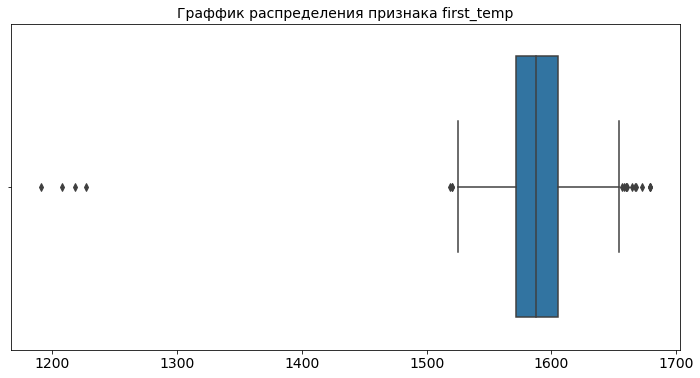

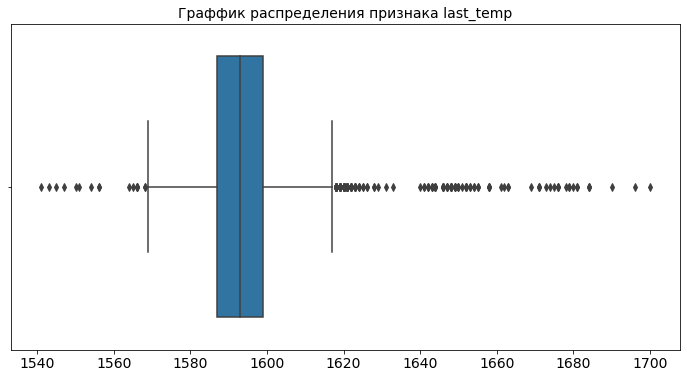

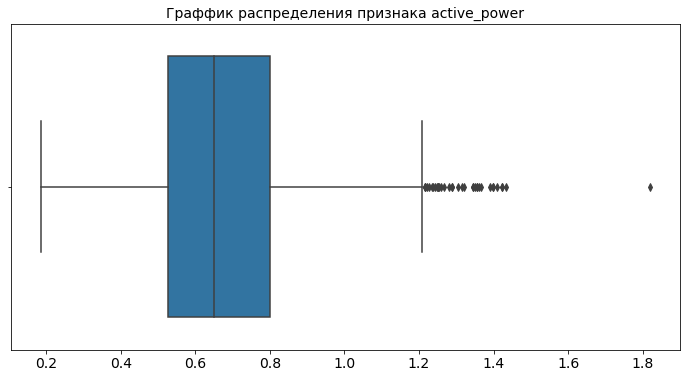

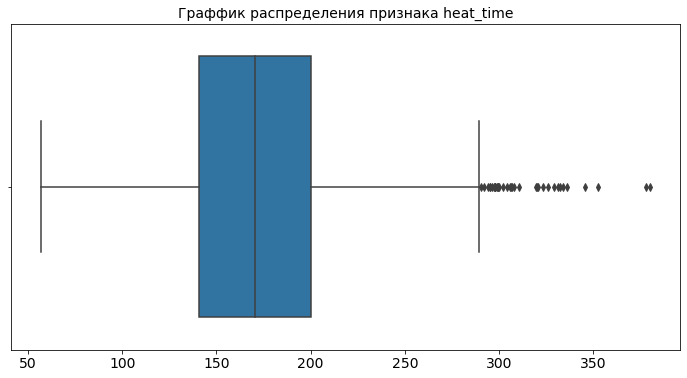

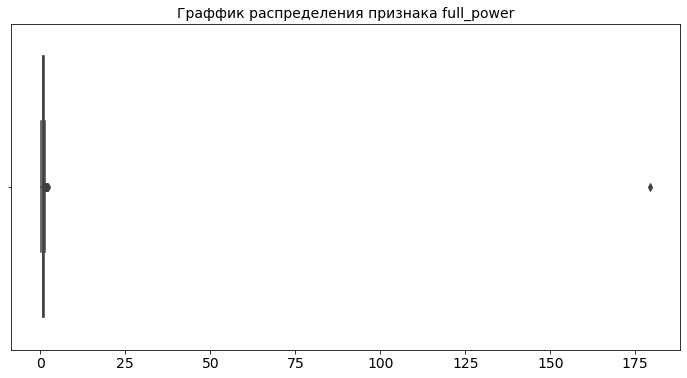

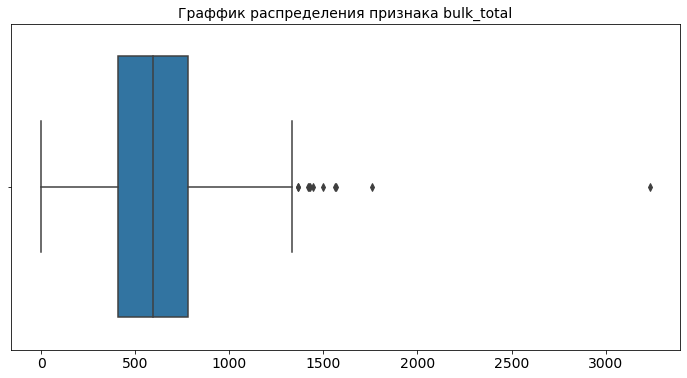

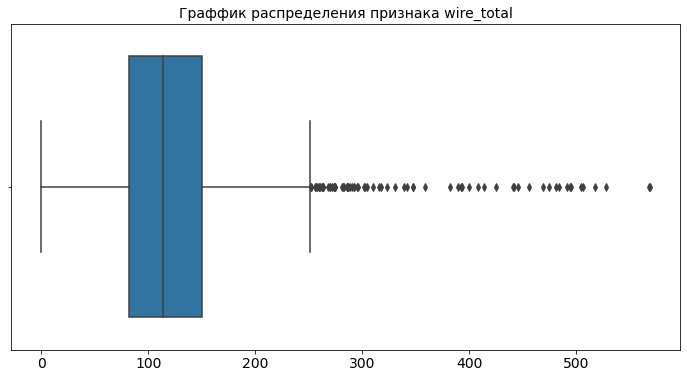

In [32]:
# построим графики распределения
check = ['first_temp', 'last_temp', 'active_power', 'heat_time', 'full_power', 'bulk_total', 'wire_total']
for col in data[check]:
    plt.title(f'Граффик распределения признака {col}')
    sns.boxplot(data[col])
    plt.xlabel('')
    plt.show()

In [33]:
# напишем функцию для удаления выбросов
def drop_anomalies(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[col] > (Q1-3*IQR)) & (data[col] < (Q3+3*IQR))]
    return data

In [34]:
for col in check:
    data = drop_anomalies(data, col)

In [35]:
data

,first_temp,last_temp,active_power,bulk_1,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,bulk_total,wire_total
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,0.975629,0.0,0.0,0.0,206.0,0.0,150.0,154.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0,60.059998
2,1581.0,1602.0,0.763150,0.0,0.0,0.0,206.0,0.0,149.0,154.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,582.0,96.052315
3,1596.0,1599.0,0.505176,0.0,0.0,0.0,205.0,0.0,152.0,153.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,544.0,91.160157
4,1601.0,1625.0,0.802313,0.0,0.0,0.0,207.0,0.0,153.0,154.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,595.0,89.063515
5,1576.0,1602.0,0.836793,0.0,0.0,0.0,203.0,0.0,151.0,152.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,584.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,0.802673,0.0,90.0,0.0,256.0,0.0,129.0,223.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,719.0,89.150879
2496,1554.0,1591.0,0.700511,0.0,122.0,0.0,256.0,0.0,129.0,226.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,796.0,114.179527
2497,1571.0,1589.0,0.737460,0.0,0.0,0.0,230.0,0.0,124.0,226.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,665.0,103.134723


## Вывод:

Итак, мы подготовили финальную таблицу **data**, в которой:
- отсутствуют пропуски и выбросы
- добавлены новые признаки (`first_temp`, `last_temp`, `active_power`, `full_power`, `heat_time`)


Можем приступать к обучению моделей, но перед этим проверим наши признаки на мультиколлинеарность

# Обучение моделей

### Проверка на мультиколлинеарность

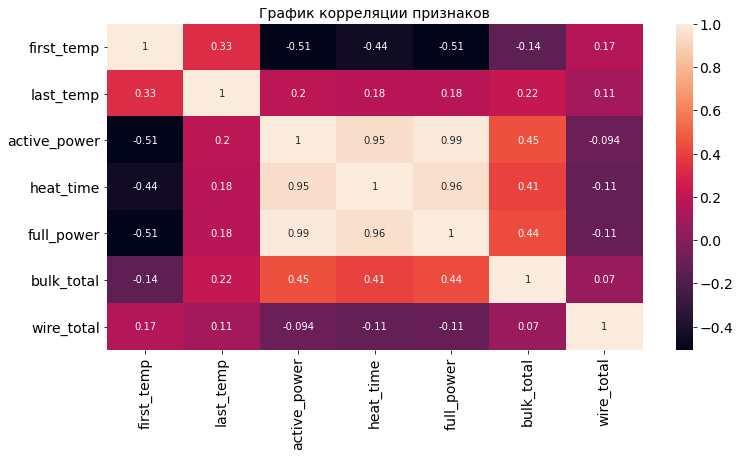

In [36]:
sns.heatmap(data[check].corr(), annot=True)
plt.title('График корреляции признаков');

Видим, что признак `heat_time` тесно связан с признаками `active_power` и `full_power`. Что логично: чем больше активная или полная мощность, тем быстрее происходит нагрев. Удалим его. При анализе важности признаков выделим для каждой модели ту мощность, которая будет показывать лучший результат.

In [37]:
data = data.drop(columns=['heat_time'])

In [38]:
target = data['last_temp']
features = data.drop(columns='last_temp')

In [39]:
# Отделим 25% данных для валидационной и тестовой выборок
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12)

In [40]:
# Проверим размерность выборок
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(1764, 30) (588, 30)
(1764,) (588,)


## Baseline модель

Перед тем, как приступить к обучению модели, подбору подходящих параметров и исследованию важности признаков для каждой модели, создадим простейшую модель, которая всегда предсказывает среднее. Так мы сможем сравнить результаты нашей будущей модели с результатами dummy модели, которая выдает только один вариант

In [41]:
dummy_reg = DummyRegressor(strategy='mean')

dummy_reg.fit(features_train, target_train)

pred = dummy_reg.predict(features_test)

print(mae(target_test, pred))

7.869001342033408


Теперь мы знаем, что если предсказывать всегда среднее значение, то МАЕ такой модели -- 7.69

## RandomForest 

Напишем функцию, которая будет выводить и сохранять в словарь результаты нашей модели

In [42]:
models = dict()

In [43]:
def submit_model(title, model, X_train, y_train, X_test, y_test): 

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
        
    train_score = mae(y_train, train_pred)
    cv_score = abs(np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')))
    test_score = mae(y_test, test_pred)
    
    def print_score(data_name, score):
        print(f'МАЕ на {data_name}: {score}')
                                                                             
    print(f'Модель "{title}":')
    print_score('обучающей', train_score)
    print_score('кросс-валидация', cv_score)
    print_score('тестовой', test_score)
                           
    models[title] = {'название': title, 
                     'на обучающей выборке': train_score,
                     'на кросс-валидации': cv_score,
                     'на тестовой': test_score}

Напишем пайплайн для случайного леса, потому что я уже давно хотела попрактиковаться в его написании

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [45]:
# опишем последовательность преобразований: 
# так как мы не удаляли выбросы в данных о добавочных материалах, используем RobustScaler, он уменьшает их влияние

scaler = ColumnTransformer(transformers=[
    ('std', StandardScaler(), ['first_temp', 'active_power']),
    ('robust', RobustScaler(), ['bulk_1','bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
                                'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9','bulk_10',
                                'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 
                                'wire_1', 'wire_2', 'wire_3', 'wire_4', 
                                'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'])
], remainder='passthrough') 

In [46]:
p = Pipeline(steps=[('scale', scaler),  # Трансформеры
                    ('forest', RandomForestRegressor(random_state=12))])

In [47]:
p.fit(features_train, target_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', StandardScaler(),
                                                  ['first_temp',
                                                   'active_power']),
                                                 ('robust', RobustScaler(),
                                                  ['bulk_1', 'bulk_2', 'bulk_3',
                                                   'bulk_4', 'bulk_5', 'bulk_6',
                                                   'bulk_7', 'bulk_8', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'wire_1', 'wire_2', 'wire_3',
                                                   'wire_4', 'wire_5', 'wire_6',
     

In [48]:
# посмотрим на результат модели
submit_model('Случайный лес с параметрами по умолчанию', p, features_train, target_train, features_test, target_test)

Модель "Случайный лес с параметрами по умолчанию":
МАЕ на обучающей: 2.472148526077097
МАЕ на кросс-валидация: 6.734331065759636
МАЕ на тестовой: 6.375459183673465


In [49]:
# rf_params = {'forest__max_depth':         range(10, 50, 10),
#              'forest__n_estimators':      range(100, 500, 50),
#              'forest__min_samples_split': range(2, 5, 10)}

# rf_grid = GridSearchCV(p, rf_params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
# rf_grid.fit(features_train, target_train)

In [50]:
# rf_grid.best_params_

In [51]:
rf_best = RandomForestRegressor(n_estimators=450, min_samples_split=2, max_depth=10, random_state=12).fit(features_train, target_train)

In [52]:
submit_model('Случайный лес после подбора параметров', rf_best, features_train, target_train, features_test, target_test)

Модель "Случайный лес после подбора параметров":
МАЕ на обучающей: 3.833562790146323
МАЕ на кросс-валидация: 6.682890427500564
МАЕ на тестовой: 6.321791496383356


**Вывод:** 

Нам удалось улучшить результат модели с помощью подбора параметров, ура!

## Feature_importances для RandomForest 
Построим график важности признаков для случайного леса. Попробуем улучшить результат, выделив важные признаки

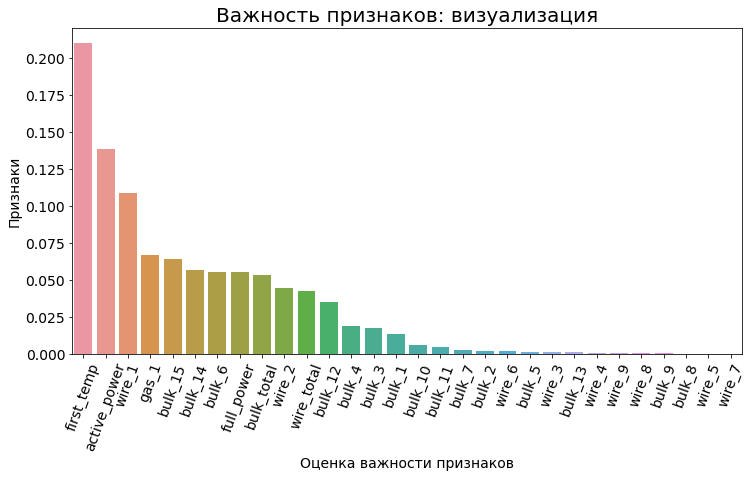

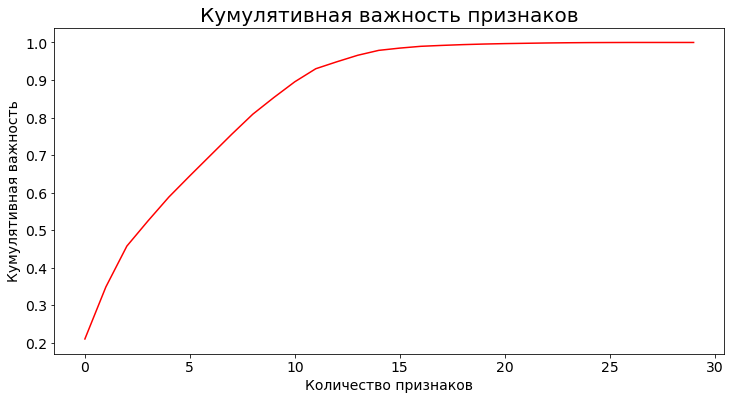

In [53]:
# построим график
def feature_imp_plot(model):
    
    # Создадим фрейм данных, упорядоченный по важности функций
    global feature_importances
    feature_importances = pd.DataFrame({'feature': list(features_train.columns), 'importance': model.feature_importances_}).sort_values('importance', ascending = False)
    
    # Построим график важности признаков
    ax = sns.barplot(x='feature', y='importance', data=feature_importances)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Важность признаков: визуализация', fontsize=20)
    plt.xticks(rotation=70)
    plt.show();    
    
    # Нормализуем признаки
    feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['importance_normalized'])
    
    # Построим график кумулятивной важности
    plt.plot(list(range(len(feature_importances))), feature_importances['cumulative_importance'], 'r-')
    plt.xlabel('Количество признаков') 
    plt.ylabel('Кумулятивная важность') 
    plt.title('Кумулятивная важность признаков', fontsize=20)
    plt.show();
    
feature_imp_plot(rf_best)

In [54]:
feature_importances.sort_values(by='cumulative_importance', ascending=True)

,feature,importance,importance_normalized,cumulative_importance
0,first_temp,0.209940,0.209940,0.209940
1,active_power,0.138671,0.138671,0.348611
19,wire_1,0.108843,0.108843,0.457454
18,gas_1,0.066675,0.066675,0.524129
8,bulk_15,0.063949,0.063949,0.588078
7,bulk_14,0.056595,0.056595,0.644673
13,bulk_6,0.055480,0.055480,0.700153
17,full_power,0.055437,0.055437,0.755590
28,bulk_total,0.053309,0.053309,0.808899
20,wire_2,0.044298,0.044298,0.853197


На графике кумулятивной важности признаков можем заметить, что ценную для модели роль играют 13 признаков. Выделим их отдельно

In [60]:
# сохраним важные признаки
threshold = 0.99

features_to_keep = list(feature_importances[feature_importances['cumulative_importance'] < threshold]['feature'])

In [61]:
# создадим новые выборки с меньшим количеством признаков
rf_features_train = features_train[features_to_keep]
rf_features_test = features_test[features_to_keep]

In [62]:
rf_features_train.columns

Index(['first_temp', 'active_power', 'wire_1', 'gas_1', 'bulk_15', 'bulk_14',
       'bulk_6', 'full_power', 'bulk_total', 'wire_2', 'wire_total', 'bulk_12',
       'bulk_4', 'bulk_3', 'bulk_1', 'bulk_10', 'bulk_11'],
      dtype='object')

In [63]:
rf_best.fit(X=rf_features_train, y=target_train)

RandomForestRegressor(max_depth=10, n_estimators=450, random_state=12)

In [64]:
submit_model('Случайный лес после отбора признаков', rf_best, rf_features_train, target_train, rf_features_test, target_test)

Модель "Случайный лес после отбора признаков":
МАЕ на обучающей: 3.8106509903088153
МАЕ на кросс-валидация: 6.67258797126262
МАЕ на тестовой: 6.31323160024514


**Вывод:** с помощью оценки важностей признаков и обучении модели только на них, нам удалось улучшить показатель МАЕ

## CatBoost

In [65]:
cat_model = CatBoostRegressor(random_state=12,
                              eval_metric='MAE',
                              iterations=1000,
                              verbose=False)

cat_model.fit(X=features_train, y=target_train, early_stopping_rounds=10)

In [66]:
# посмотрим на результат модели
submit_model('CatBoost с параметрами по умолчанию', cat_model, features_train, target_train, features_test, target_test)

Модель "CatBoost с параметрами по умолчанию":
МАЕ на обучающей: 3.1108963871449538
МАЕ на кросс-валидация: 6.583149006618854
МАЕ на тестовой: 6.296272421367356


In [67]:
# # CatBoost параметры
# cat_params = {
#     'learning_rate':     np.arange(0.03, 0.2, 0.05),
#     'depth':             np.arange(6, 10),
#     'l2_leaf_reg':       np.arange(0.5, 3, 0.5)
# }

In [68]:
# cat_grid = RandomizedSearchCV(cat_model, cat_params, cv=3, n_jobs=-1)
# cat_grid.fit(X=features_train, y=target_train)
# cat_grid.best_params_

In [69]:
cat_best = CatBoostRegressor(random_state=12,
                              eval_metric='MAE',
                              iterations=1000,
                              learning_rate = 0.03,
                              l2_leaf_reg = 2,
                              depth = 6,
                              verbose=False)

cat_best.fit(X=features_train, y=target_train, early_stopping_rounds=10)

In [70]:
submit_model('CatBoost после подбора параметров', cat_best, features_train, target_train, features_test, target_test)

Модель "CatBoost после подбора параметров":
МАЕ на обучающей: 3.5784561914257202
МАЕ на кросс-валидация: 6.543672096588366
МАЕ на тестовой: 6.276682577164674


**Вывод:** подбор параметров для CatBoost не дал особых результатов. Зато он превзошел показатель случайного леса на тестовой выборке почти на 0,2 значения

## Feature_importances для CatBoost 
Откроем для себя библиотеку для оценки важности признаков -- shap

In [71]:
# если не установлен shap, то вот загрузчик :)
#pip install shap
import shap

In [72]:
shap.initjs()

In [73]:
explainer = shap.TreeExplainer(cat_best)

In [74]:
shap_values = explainer.shap_values(Pool(features_train, target_train))

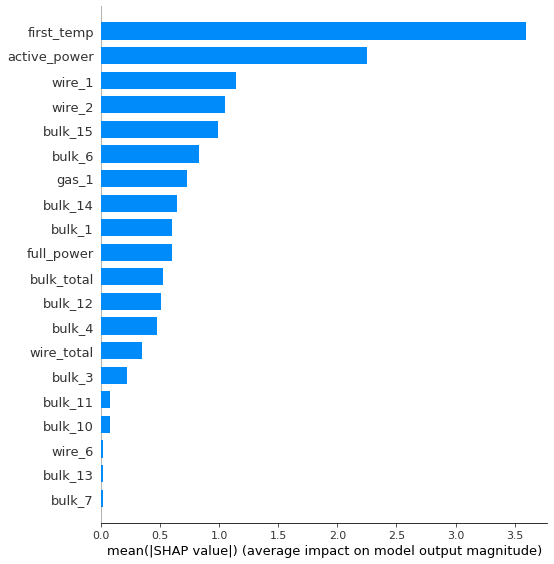

In [75]:
shap.summary_plot(shap_values, features_train, plot_type="bar", feature_names=features_train.columns, title='yo')

In [76]:
# выделим важные признаки
vals= np.abs(shap_values).mean(0)
feature_importance_cat = pd.DataFrame(list(zip(features_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance_cat.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance_cat.head(9)

,col_name,feature_importance_vals
0,first_temp,3.596755
1,active_power,2.250357
19,wire_1,1.142564
20,wire_2,1.047649
8,bulk_15,0.987728
13,bulk_6,0.827207
18,gas_1,0.728781
7,bulk_14,0.641476
2,bulk_1,0.601397


In [77]:
cat_best_features = list(feature_importance_cat['col_name'].iloc[:8])

In [78]:
cat_best_features

['first_temp',
 'active_power',
 'wire_1',
 'wire_2',
 'bulk_15',
 'bulk_6',
 'gas_1',
 'bulk_14']

In [79]:
# создадим новые выборки с меньшим количеством признаков
cat_features_train = features_train[cat_best_features]
cat_features_test = features_test[cat_best_features]

In [80]:
cat_best.fit(X=cat_features_train, y=target_train)

In [81]:
submit_model('CatBoost после отбора признаков', cat_best, cat_features_train, target_train, cat_features_test, target_test)

Модель "CatBoost после отбора признаков":
МАЕ на обучающей: 3.928503549127357
МАЕ на кросс-валидация: 6.777695288821537
МАЕ на тестовой: 6.235601853373161


**Вывод:** мы смогли немного улучшить результат CatBoost, ура!

# Итоги
Посмотрим на результаты наших моделей

In [82]:
score_table = pd.DataFrame.from_dict(data=models, orient='index').sort_values('на тестовой', ascending=True)

In [83]:
score_table

,название,на обучающей выборке,на кросс-валидации,на тестовой
CatBoost после отбора признаков,CatBoost после отбора признаков,3.928504,6.777695,6.235602
CatBoost после подбора параметров,CatBoost после подбора параметров,3.578456,6.543672,6.276683
CatBoost с параметрами по умолчанию,CatBoost с параметрами по умолчанию,3.110896,6.583149,6.296272
Случайный лес после отбора признаков,Случайный лес после отбора признаков,3.810651,6.672588,6.313232
Случайный лес после подбора параметров,Случайный лес после подбора параметров,3.833563,6.682890,6.321791
Случайный лес с параметрами по умолчанию,Случайный лес с параметрами по умолчанию,2.472149,6.734331,6.375459


Итак, нам удалось добиться результата в 6,2 МАЕ на тестовой выборке с помощью CatBoost после отбора признаков. Значит, в среднем наша предсказательная модель ошибается на 6,2 градуса. Учитывая, что речь идет о температурах выше 1500 градусов, результат довольно неплохой :)

Отбор важности признаков и подбор параметров помогли нам улучшить результаты наших моделей. Все логично!
